In [32]:
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from biological_fuzzy_logic_networks.draw import draw_BioFuzzNet
from biological_fuzzy_logic_networks.DREAM.DREAMBioFuzzNet import DREAMBioFuzzNet
from biological_fuzzy_logic_networks.DREAM.DREAMdataset import DREAMBioFuzzDataset
from biological_fuzzy_logic_networks.utils import read_sif
from biological_fuzzy_logic_networks.DREAM_analysis.utils import data_to_nodes_mapping, inhibitor_mapping

In [33]:
node_names_to_data_mapping = data_to_nodes_mapping()
inhibitor_mapping = inhibitor_mapping()

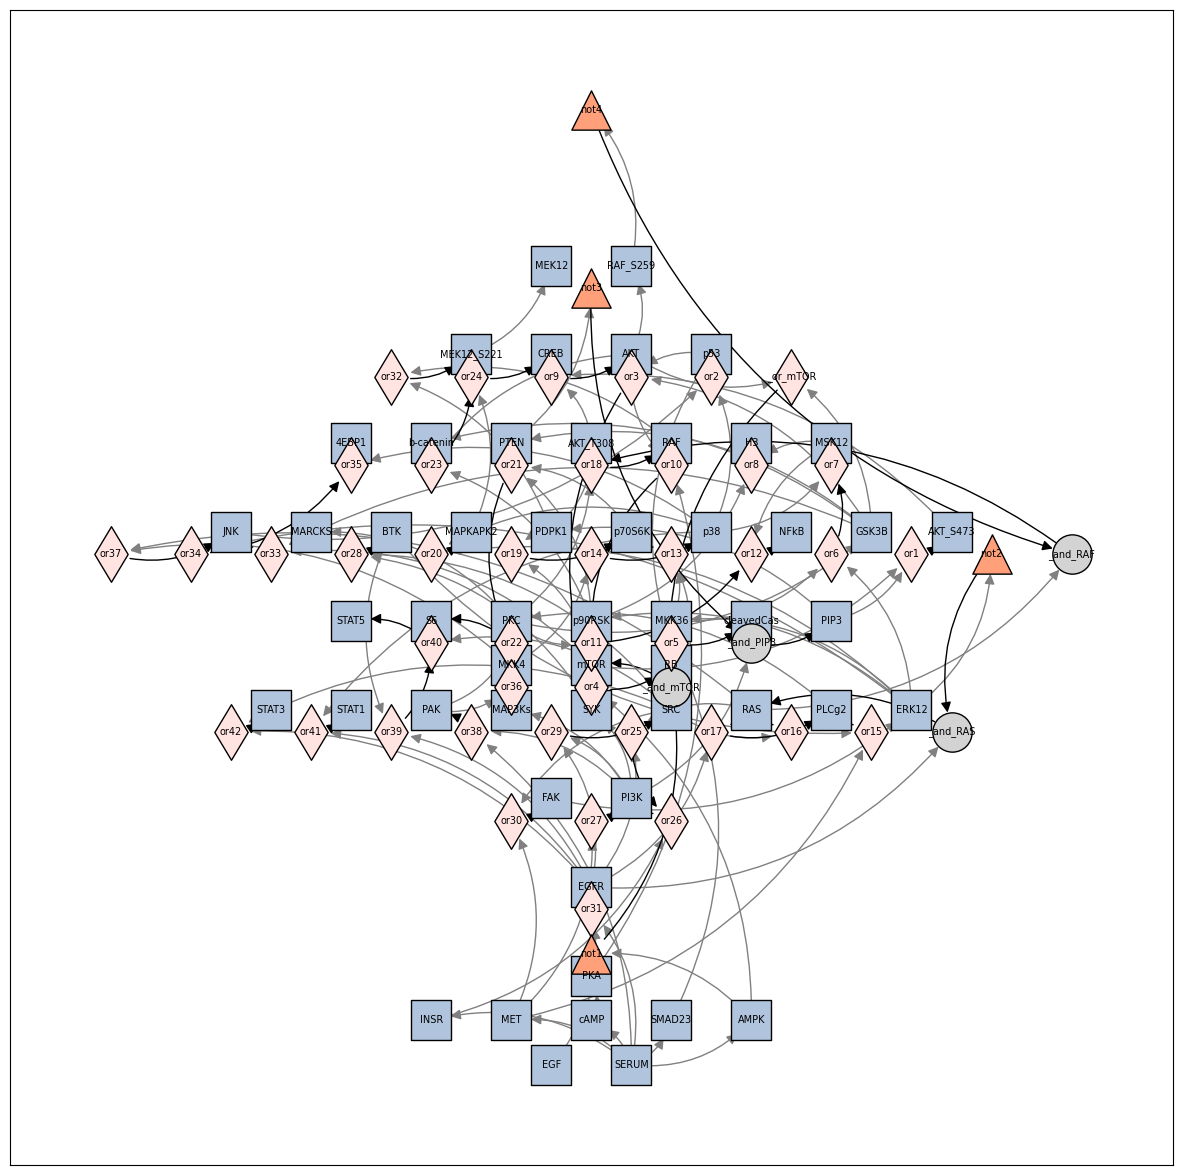

In [34]:
nodes, edges = read_sif("/dccstor/ipc1/CAR/DREAM/DREAMdata/DREAM_PKN_for_BFZ_input.sif")
edges[("JNK", "p53")] = 1
edges[("mTOR", "AKT_S473")] = 1
my_model = DREAMBioFuzzNet(nodes, edges)
p = draw_BioFuzzNet(my_model)

In [35]:
cl_data = pd.read_csv("/dccstor/ipc1/CAR/DREAM/DREAMdata/ZR7530.csv")
non_marker_cols = ["treatment", "cell_line", "time", "cellID", "fileID", "inhibitor"]

cl_data = cl_data[cl_data["time"]==9]
cl_data.loc[:, ["EGF", "SERUM"]]  = 1
cl_data.loc[:,"inhibitor"] = [inhibitor_mapping[treatment]  for treatment in cl_data["treatment"]]

cl_data = cl_data.rename(columns = node_names_to_data_mapping)

markers = [c for c in cl_data.columns if not c in non_marker_cols]
scaler = MinMaxScaler()
cl_data[markers] = scaler.fit_transform(cl_data[markers])
non_network_measurements = [m for m in markers if m not in node_names_to_data_mapping.values()]
cl_data = cl_data.drop(["treatment", "cell_line", "time", "cellID", "fileID"] + non_network_measurements, axis=1)
cl_data.loc[:, ["EGF", "SERUM"]]  = 1

cl_data = cl_data.sample(n=1000)

/tmp/ipykernel_1071827/908993602.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  cl_data.loc[:, ["EGF", "SERUM"]]  = 1
/tmp/ipykernel_1071827/908993602.py:15: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  cl_data.loc[:, ["EGF", "SERUM"]]  = 1


In [36]:
train, test = train_test_split(cl_data)
print(train.shape)
print(test.shape)
train = train.to_dict("list")
test = test.to_dict("list")

train_data = {k: torch.DoubleTensor(v) for k, v in train.items() if k in markers}
test_data = {k: torch.DoubleTensor(v) for k, v in test.items() if k in markers}

train_inhibitors = {m1: torch.DoubleTensor([10. if m==m1 else 1. for m in train["inhibitor"]]) for m1 in my_model.nodes()}
test_inhibitors = {m1: torch.DoubleTensor([10. if m==m1 else 1. for m in test["inhibitor"]]) for m1 in my_model.nodes()}

input_train = {"SERUM": train["SERUM"], "EGF": train["EGF"]}
input_test = {"SERUM": test["SERUM"], "EGF": test["EGF"]} 




(750, 35)
(250, 35)


In [37]:
# specify some optimisation parameters

learning_rate = 5e-3
epochs = 10 
batch_size = 300

In [38]:
loss = my_model.conduct_optimisation(input = input_train,
                                     test_input = input_test,
                                     ground_truth=train_data,
                                     test_ground_truth=test_data,
                                     train_inhibitors = train_inhibitors,
                                     test_inhibitors = test_inhibitors,
                                     epochs = epochs,
                                     learning_rate= learning_rate,
                                     batch_size= batch_size,
                                     convergence_check=True
                                         )

  0%|                                                                                                    | 0/10 [00:00<?, ?it/s]/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM/DREAMBioFuzzNet.py:53: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM/DREAMBioFuzzNet.py:142: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM/DREAMBioFuzzNet.py:53: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. Thi

 40%|████████████████████████████████████▊                                                       | 4/10 [03:51<05:47, 57.99s/it]/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM/DREAMBioFuzzNet.py:53: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM/DREAMBioFuzzNet.py:142: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM/DREAMBioFuzzNet.py:53: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. Thi

 80%|█████████████████████████████████████████████████████████████████████████▌                  | 8/10 [07:45<01:56, 58.43s/it]/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM/DREAMBioFuzzNet.py:53: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM/DREAMBioFuzzNet.py:142: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM/DREAMBioFuzzNet.py:53: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. Thi

In [39]:
loss

,time,loss,phase
0,2023-04-20 04:17:19.288650,0.087537,train
1,2023-04-20 04:17:37.765639,0.086165,train
2,2023-04-20 04:17:56.476457,0.085464,train
3,2023-04-20 04:17:57.075130,0.085034,test
4,2023-04-20 04:18:16.129278,0.084970,train
5,2023-04-20 04:18:35.040948,0.084093,train
6,2023-04-20 04:18:53.829185,0.084514,train
7,2023-04-20 04:18:54.426430,0.083103,test
8,2023-04-20 04:19:14.332111,0.083520,train
9,2023-04-20 04:19:34.339331,0.082893,train
